# Alle Daten im Überblick

Im letzten Schritt wollen wir nun noch einen Blick auf die Daten aus den unterschiedlichen Quellen machen und uns mögliche Zusammenhänge für die Interpretation anschauen. Zunächst werden wieder die notwendigen Libraries geladen.

In [12]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Einlesen aller HDF5-Files

## ZAMG

Das File wird in einen Panda-Dataframe eingelesen.

In [13]:
zamg = pd.read_hdf('../data/zamg/zamg.h5') 
zamg["date"] = pd.to_datetime(zamg["date"])
print(zamg.dtypes)
print(zamg)

location            object
date        datetime64[ns]
rain               float64
deg                float64
dtype: object
     location       date  rain   deg
0     Güssing 2022-05-23   0.0  19.6
1     Güssing 2022-05-24  15.1  19.7
2     Güssing 2022-05-25  16.5  17.6
3     Güssing 2022-05-26   0.0  18.1
4     Güssing 2022-05-27  12.0  20.1
..        ...        ...   ...   ...
131  Poysdorf 2022-06-20   0.6  23.0
132  Poysdorf 2022-06-21   0.0  18.7
133  Poysdorf 2022-06-22   0.0  19.8
134  Poysdorf 2022-06-23   0.0  23.2
135  Poysdorf 2022-06-24   0.0  16.0

[136 rows x 4 columns]


## ECAD

### Files laden

Sowohl das die Regendaten als auch die Temperaturdaten werden in einen Panda-Dataframe eingelesen. Die Spalte Date wird nun noch als "Datetime" gecastet, der Name der Station wird passend zur Station-ID hinzugefügt.

In [14]:
ecadRR = pd.read_hdf('../data/ecad/RR.h5') 
ecadRR["DATE"] = pd.to_datetime(ecadRR["DATE"], format='%Y%m%d')

# add station name
ecadRR.loc[ecadRR["SOUID"] == 234717 , "name"] = "KREMS"
ecadRR.loc[ecadRR["SOUID"] == 234938 , "name"] = "NEUSIEDL AM SEE"
ecadRR.loc[ecadRR["SOUID"] == 235003 , "name"] = "POYSDORF"
ecadRR.loc[ecadRR["SOUID"] == 236251 , "name"] = "GÜSSING"

print(ecadRR.dtypes)
print(ecadRR)

ecadTG = pd.read_hdf('../data/ecad/TG.h5') 
ecadTG["DATE"] = pd.to_datetime(ecadTG["DATE"], format='%Y%m%d')

# add station name
ecadTG.loc[ecadTG["SOUID"] == 234722 , "name"] = "KREMS"
ecadTG.loc[ecadTG["SOUID"] == 234943 , "name"] = "NEUSIEDL AM SEE"
ecadTG.loc[ecadTG["SOUID"] == 235008 , "name"] = "POYSDORF"
ecadTG.loc[ecadTG["SOUID"] == 236256 , "name"] = "GÜSSING"

print(ecadTG.dtypes)
print(ecadTG)

SOUID             int64
DATE     datetime64[ns]
RR                int64
name             object
dtype: object
        SOUID       DATE  RR     name
0      234717 1936-01-02   1    KREMS
1      234717 1936-01-03   3    KREMS
2      234717 1936-01-04  44    KREMS
3      234717 1936-01-05  11    KREMS
4      234717 1936-01-06   0    KREMS
...       ...        ...  ..      ...
99910  236251 2021-12-27   0  GÜSSING
99911  236251 2021-12-28  41  GÜSSING
99912  236251 2021-12-29   6  GÜSSING
99913  236251 2021-12-30   1  GÜSSING
99914  236251 2021-12-31   0  GÜSSING

[99915 rows x 4 columns]
SOUID             int64
DATE     datetime64[ns]
TG              float64
name             object
dtype: object
        SOUID       DATE   TG     name
0      234722 1936-01-01  3.8    KREMS
1      234722 1936-01-02  3.3    KREMS
2      234722 1936-01-03  3.4    KREMS
3      234722 1936-01-04  5.1    KREMS
4      234722 1936-01-05  3.6    KREMS
...       ...        ...  ...      ...
98455  236256 2021-12-27 

### Zusammenführen der Objekte ecadTG und ecadRR

Die beiden Files werden nun nach beiden Schlüsseln zusammengeführt und die Regen- bzw. Temperaturwerte werden als Spalten hinzugefügt, sodass wir am Ende nur noch einen großen ECAD-Datensatz vor uns haben.

In [15]:
# beide Schlüssel (name, DATE) in eine Tabelle
ecad = pd.concat([ecadRR[['name','DATE']], ecadTG[['name','DATE']]])
print(ecad.shape)
# eindeutige Werte für den Schlüssel (name, DATE)
ecad = ecad.groupby(by = ['name', 'DATE']).size().reset_index().rename(columns={0:'count'})[['name','DATE']]
print(ecad.shape)

# hinzufügen von RR und TG Werten
ecad = pd.merge(ecad, ecadRR[['name','DATE','RR']], how = 'left', on = ['name', 'DATE'])
ecad = pd.merge(ecad, ecadTG[['name','DATE','TG']], how = 'left', on = ['name', 'DATE'])
ecad

(198375, 2)
(99958, 2)


,name,DATE,RR,TG
0,GÜSSING,1948-01-01,0.0,-6.6
1,GÜSSING,1948-01-02,0.0,-4.8
2,GÜSSING,1948-01-03,0.0,-1.5
3,GÜSSING,1948-01-04,0.0,3.5
4,GÜSSING,1948-01-05,0.0,0.6
...,...,...,...,...
99953,POYSDORF,2021-12-27,0.0,-1.0
99954,POYSDORF,2021-12-28,52.0,-0.5
99955,POYSDORF,2021-12-29,19.0,1.4
99956,POYSDORF,2021-12-30,14.0,4.7


## GeDaBa

Die beiden Files für das Burgenland sowie für Niederösterreich werden in Panda-Dataframes eingelesen und zusammengefügt. "Jahr" und "gkz5" (Gemeindekennzahl) werden als Integer gecastet.

In [16]:
bl = pd.read_hdf('../data/agrar/burgenland.h5') 
noe = pd.read_hdf('../data/agrar/noe.h5') 
gedaba = pd.concat([bl, noe])
gedaba = gedaba.astype({"jahr": int, "gkz5": int})
print(gedaba.dtypes)
print(gedaba)

gkz5              int64
gemeindename     object
jahr              int64
merkmal          object
wert            float64
dtype: object
        gkz5             gemeindename  jahr     merkmal        wert
0      10101               Eisenstadt  2000  Weingärten  487.330000
1      10101               Eisenstadt  2000      Weizen  235.310000
2      10101               Eisenstadt  2001  Weingärten  474.840000
3      10101               Eisenstadt  2001      Weizen  246.510000
4      10101               Eisenstadt  2002  Weingärten  507.810000
...      ...                      ...   ...         ...         ...
14154  32530  Zwettl-Niederösterreich  2017      Weizen  431.599976
14155  32530  Zwettl-Niederösterreich  2018      Weizen  458.019989
14156  32530  Zwettl-Niederösterreich  2019      Weizen  449.880005
14157  32530  Zwettl-Niederösterreich  2020      Weizen  441.269989
14158  32530  Zwettl-Niederösterreich  2021      Weizen  617.090027

[19334 rows x 5 columns]


### Filtern der betrachteten Gemeinden

Wir wollen uns nun die Gemeinden anschauen, die sich im Umkreis von 5 km um die Wetterstationen befinden, die wir aus den ZAMG- und ECAD-Daten kennen:

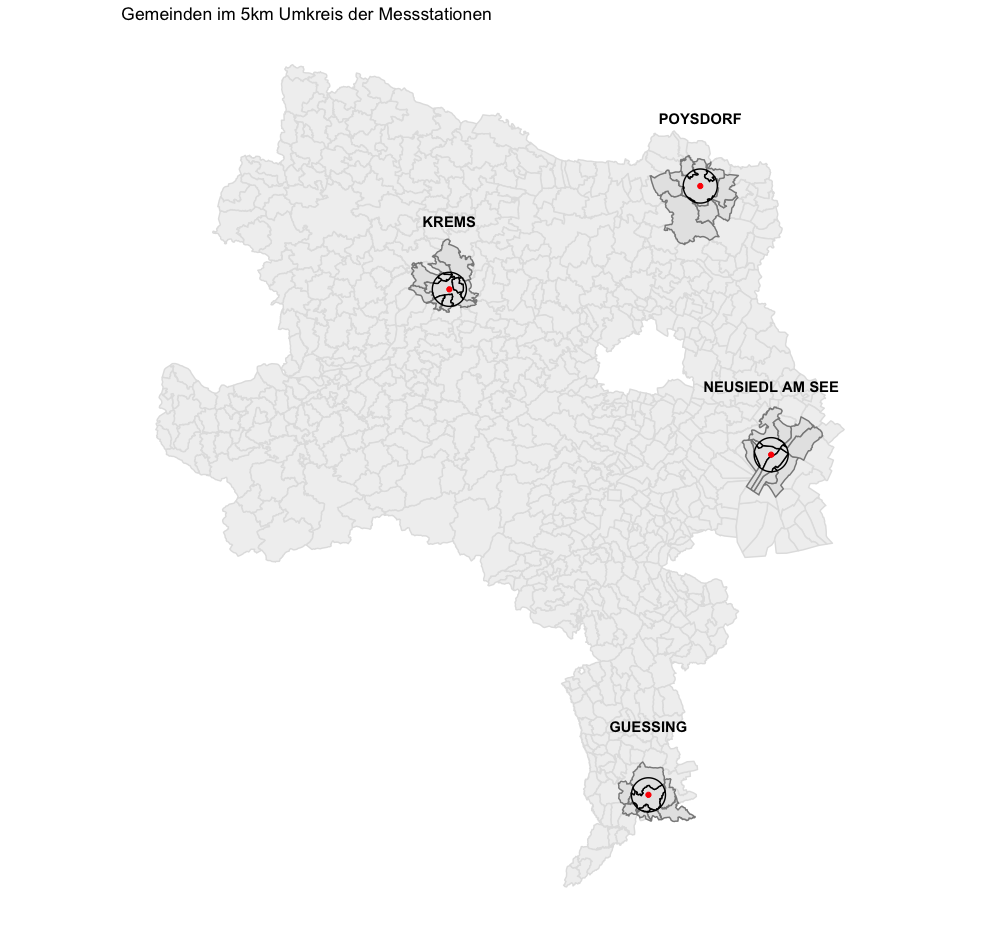

Mithilfe der Datei "gemNearby.csv", in die wir die Gemeindenamen eingetragen haben, "filtern" wir jetzt die Daten mit einem Join und werfen auch gleich Spalten weg, die wir nicht mehr benötigen.

In [17]:
gem = pd.read_csv('../data/agrar/gemNearby.csv') 
#gedaba = gedaba[gedaba.gkz5.isin(gem.id)]
gedaba = pd.merge(gedaba, gem
                 , how='inner'
                 , left_on='gkz5', right_on='id')
gedaba = gedaba.drop(columns = ['id', 'name'])
print(gedaba.shape) # 1319, 5
gedaba

(1319, 6)


,gkz5,gemeindename,jahr,merkmal,wert,SOUNAME
0,10404,Gerersdorf-Sulz,2000,Weingärten,0.310000,GÜSSING
1,10404,Gerersdorf-Sulz,2000,Weizen,128.330000,GÜSSING
2,10404,Gerersdorf-Sulz,2001,Weingärten,0.300000,GÜSSING
3,10404,Gerersdorf-Sulz,2001,Weizen,153.030000,GÜSSING
4,10404,Gerersdorf-Sulz,2002,Weingärten,0.300000,GÜSSING
...,...,...,...,...,...,...
1314,31654,Wilfersdorf,2019,Weizen,2024.929932,POYSDORF
1315,31654,Wilfersdorf,2020,Weingärten,85.160004,POYSDORF
1316,31654,Wilfersdorf,2020,Weizen,2007.069946,POYSDORF
1317,31654,Wilfersdorf,2021,Weingärten,84.779999,POYSDORF


# Basis-Visualisierung für alle Datensätze

## ZAMG Visualisierung

<AxesSubplot:xlabel='date', ylabel='deg'>

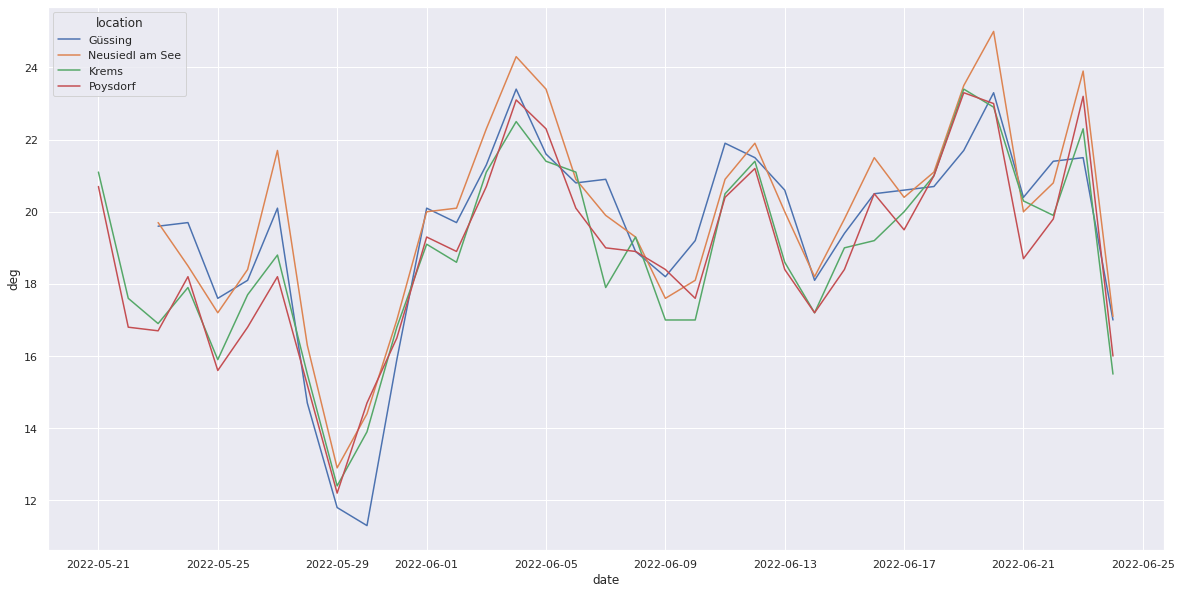

In [18]:
sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(data=zamg, x="date", y="deg", hue="location")

Ansicht der durchschnittlichen Temperatur/Tag der vier Wetterstation des ZAMG, deren Daten via Webscraping gewonnen wurden.

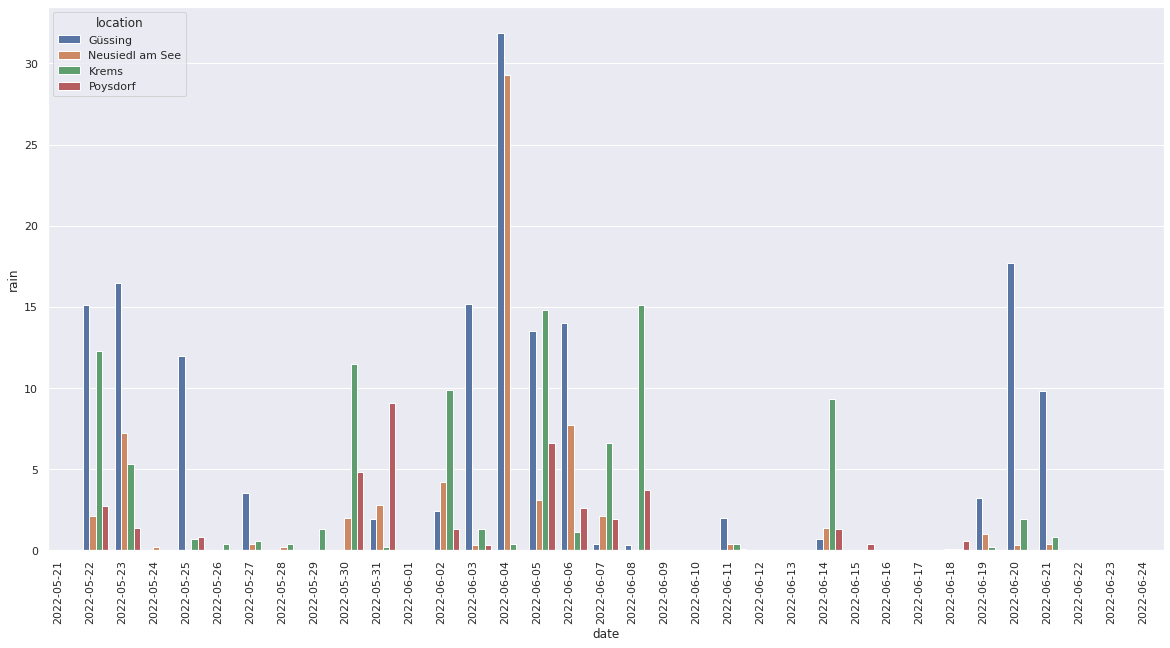

In [19]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(20,10)})
ax = sns.barplot(data=zamg, x=zamg.date, y="rain", hue="location", ax = ax)
x_dates = zamg.date.dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right')
plt.show()

Ansicht der summierten Regenmengen/Tag der vier Wetterstation des ZAMG, deren Daten via Webscraping gewonnen wurden.

## ECAD Visualisierung

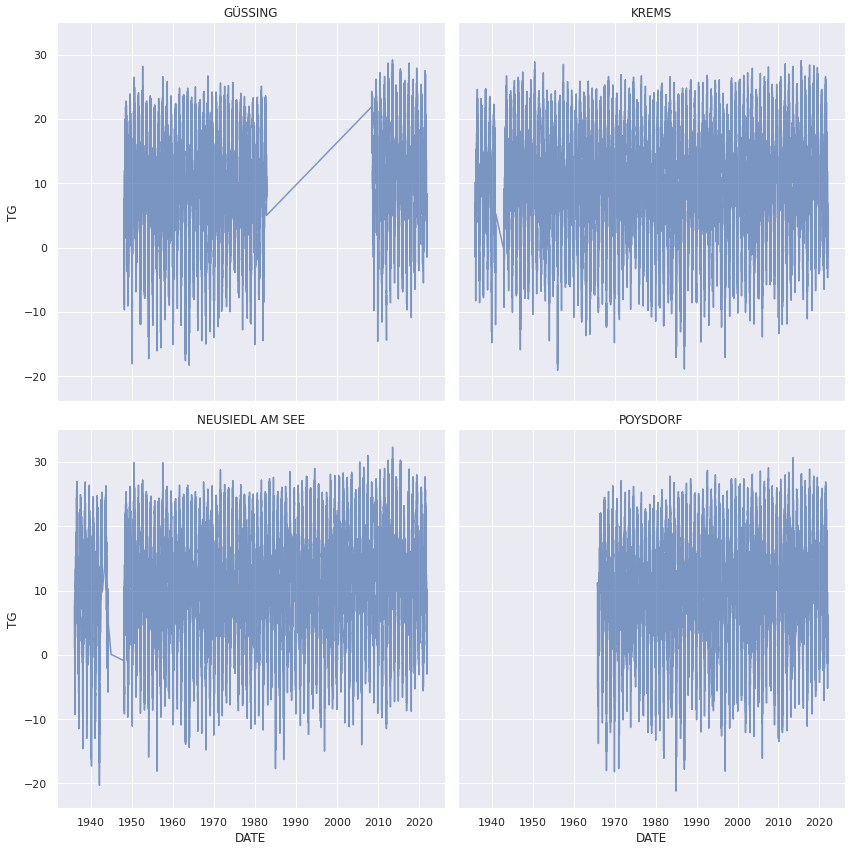

In [20]:
g = sns.FacetGrid(ecad, col="name", col_wrap=2, height=6)
g.map(sns.lineplot, "DATE", "TG", alpha=.7)
g.set_titles(col_template = '{col_name}')

Ansicht der durchschnittlichen Temperatur/Tag über die vorhandenen Datensätze des ECAD zwischen 1936 und 2021 für die 4 Stationen Güssing, Krems, Neusiedl am See und Poysdorf. Datenlücken bzw. fehlende Jahre sind gut erkennbar. Wenn man genauer hinsieht, kann man erkennen, dass es in den letzten 10 Jahren durchaus eine Tendenz nach oben gibt. 

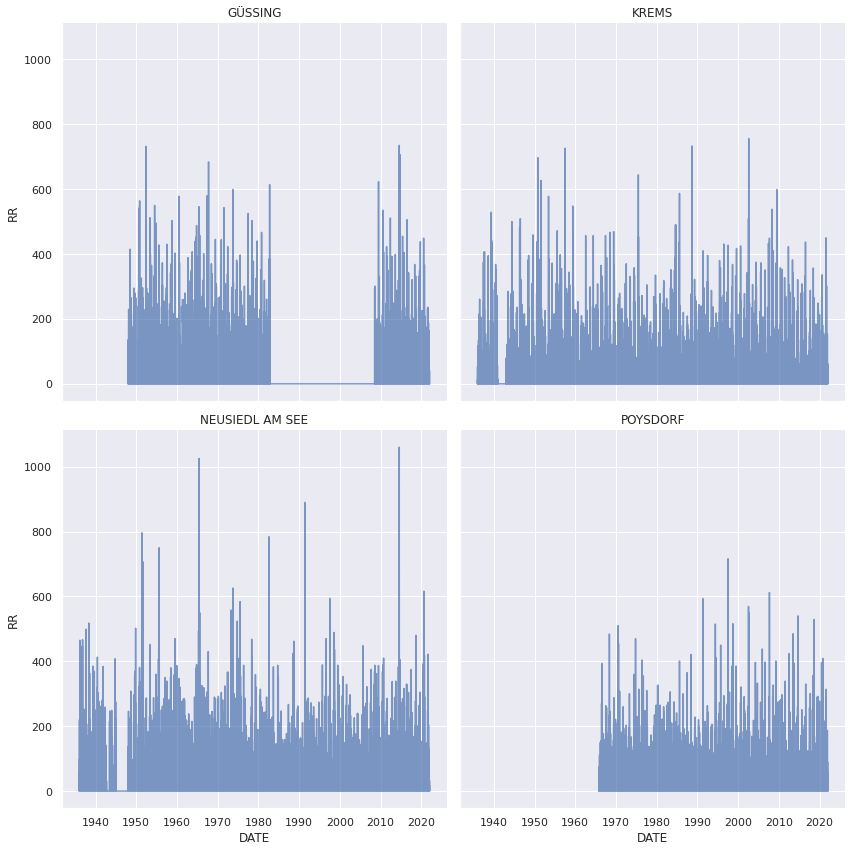

In [21]:
g = sns.FacetGrid(ecad, col="name", col_wrap=2, height=6)
g.map(sns.lineplot, "DATE", "RR", alpha=.7)
g.set_titles(col_template = '{col_name}')

Ansicht der summierten Regenmenge/Tag in 10l über die vorhandenen Datensätze des ECAD ziwschen 1936 und 2021 für die 4 Stationen Güssing, Krems, Neusiedl am See und Poysdorf. Datenlücken bzw. fehlende Jahr sind gut erkennbar. Auch sehr gut ist erkennbar, dass es in Neusiedl am See mehr geregnet hat als an den anderen Orten.

## GeDaBa Visualisierung

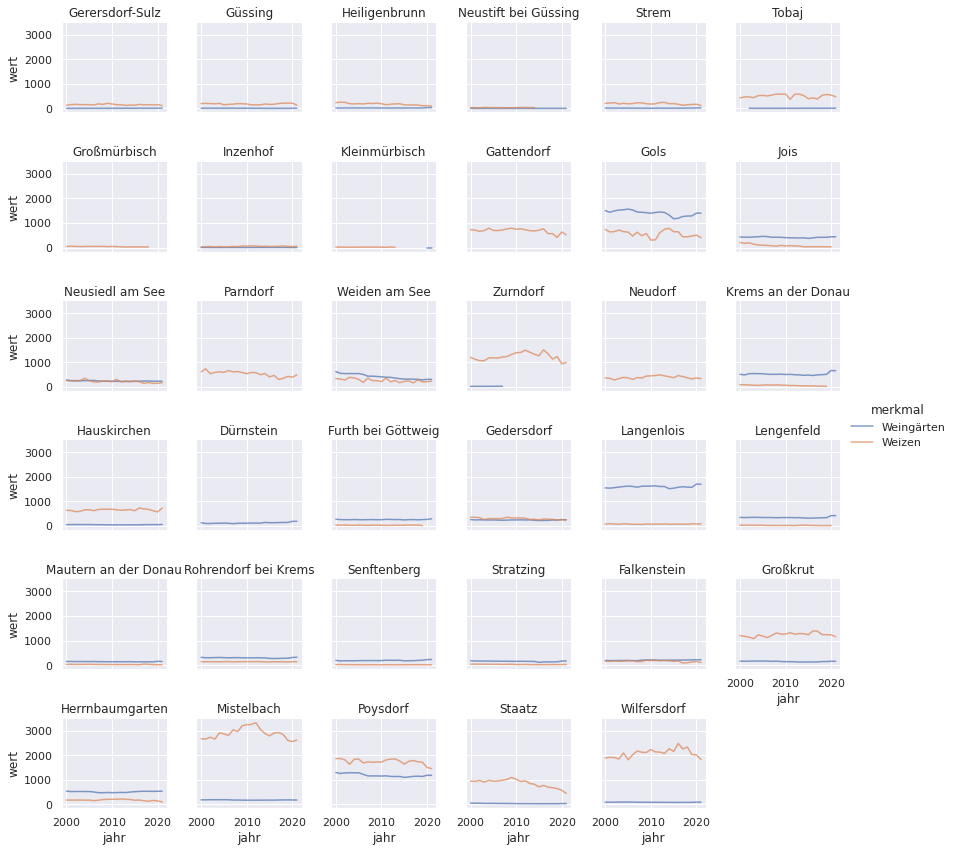

In [22]:
g = sns.FacetGrid(gedaba, col="gemeindename", hue='merkmal', col_wrap=6, height=2) # gemeindename
g.map(sns.lineplot, "jahr", "wert", alpha=.7)
g.set_titles(col_template = '{col_name}')
g.add_legend()

Ansicht der 35 Gemeinden samt den Summen der Anbauflächen in Hektar für Weizen bzw. Wein. Eine erkennbare Entwicklung in diesem Maßstab zeigen zB. Mistelbach, Poysdorf, Staatz und Wilfersdorf, wo der Weizenanbau in den letzten Jahren rückläufig ist. In Langenlois, Krems bzw, Gols kann man erkennen, dass sich hier der Weinanbau steigert.

# ZAMG-Vergleich mit ECAD Temperatur-Daten

In dieser Visualisieung wird versucht, die aktuellen ZAMG Temperature-Daten des letzten Monats, die zu Tageswerten aggregiert wurden vor dem Hintergrund der ECAD Daten zu zeigen. Für diesen Zweck wurden aus diesen Daten auch jeweils nur der Zeitraum Mai/Juni aus den vorhandenen Daten gewonnen: 

In [23]:
# extra spalte für jahre der ecad-daten
ecad['year'] = pd.DatetimeIndex(ecad['DATE']).year

# ersetzen von jahr im datum mit zamg-jahr (2020 - wegen schaltjahr)
ecad['plotdate'] = pd.to_datetime('2020-' + ecad.DATE.dt.strftime('%m') + "-" + ecad.DATE.dt.strftime('%d'))

# ecad nur für datumsbereich von zamg
#zamg.date.min() # 2022-05-21
#zamg.date.max() # 2022-06-24

ecad = ecad.set_index(['plotdate'])
ecadSimple = ecad.loc['2020-5-21':'2020-6-23']
print(ecadSimple)

# 2 jahre hinzufügen zu plotdate
ecadSimple = ecadSimple.reset_index()
ecadSimple['plotdate'] = ecadSimple['plotdate'] + pd.DateOffset(years=2)
print(ecadSimple)

                name       DATE   RR    TG  year
plotdate                                        
2020-05-21   GÜSSING 1948-05-21  0.0  11.4  1948
2020-05-22   GÜSSING 1948-05-22  0.0  13.0  1948
2020-05-23   GÜSSING 1948-05-23  0.0  14.0  1948
2020-05-24   GÜSSING 1948-05-24  0.0  14.7  1948
2020-05-25   GÜSSING 1948-05-25  0.0  14.9  1948
...              ...        ...  ...   ...   ...
2020-06-19  POYSDORF 2021-06-19  0.0  24.3  2021
2020-06-20  POYSDORF 2021-06-20  0.0  25.0  2021
2020-06-21  POYSDORF 2021-06-21  0.0  26.3  2021
2020-06-22  POYSDORF 2021-06-22  0.0  23.9  2021
2020-06-23  POYSDORF 2021-06-23  0.0  24.0  2021

[9282 rows x 5 columns]
       plotdate      name       DATE   RR    TG  year
0    2022-05-21   GÜSSING 1948-05-21  0.0  11.4  1948
1    2022-05-22   GÜSSING 1948-05-22  0.0  13.0  1948
2    2022-05-23   GÜSSING 1948-05-23  0.0  14.0  1948
3    2022-05-24   GÜSSING 1948-05-24  0.0  14.7  1948
4    2022-05-25   GÜSSING 1948-05-25  0.0  14.9  1948
...         ..

In [24]:
zamg['year'] = 2022
zamg['location'] = zamg['location'].str.upper()
zamg = zamg.rename(columns = {'location' : 'name'
                       , 'date' : 'plotdate'
                      , 'rain' : 'RR'
                      , 'deg' : 'TG'
                      }) 
zamg

,name,plotdate,RR,TG,year
0,GÜSSING,2022-05-23,0.0,19.6,2022
1,GÜSSING,2022-05-24,15.1,19.7,2022
2,GÜSSING,2022-05-25,16.5,17.6,2022
3,GÜSSING,2022-05-26,0.0,18.1,2022
4,GÜSSING,2022-05-27,12.0,20.1,2022
...,...,...,...,...,...
131,POYSDORF,2022-06-20,0.6,23.0,2022
132,POYSDORF,2022-06-21,0.0,18.7,2022
133,POYSDORF,2022-06-22,0.0,19.8,2022
134,POYSDORF,2022-06-23,0.0,23.2,2022


In [25]:
#ecadSimple
ecadzamg = pd.concat([ecadSimple[['name','plotdate', 'RR', 'TG','year']],zamg], ignore_index=True)
ecadzamg

,name,plotdate,RR,TG,year
0,GÜSSING,2022-05-21,0.0,11.4,1948
1,GÜSSING,2022-05-22,0.0,13.0,1948
2,GÜSSING,2022-05-23,0.0,14.0,1948
3,GÜSSING,2022-05-24,0.0,14.7,1948
4,GÜSSING,2022-05-25,0.0,14.9,1948
...,...,...,...,...,...
9413,POYSDORF,2022-06-20,0.6,23.0,2022
9414,POYSDORF,2022-06-21,0.0,18.7,2022
9415,POYSDORF,2022-06-22,0.0,19.8,2022
9416,POYSDORF,2022-06-23,0.0,23.2,2022


/tmp/ipykernel_260/1724956587.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


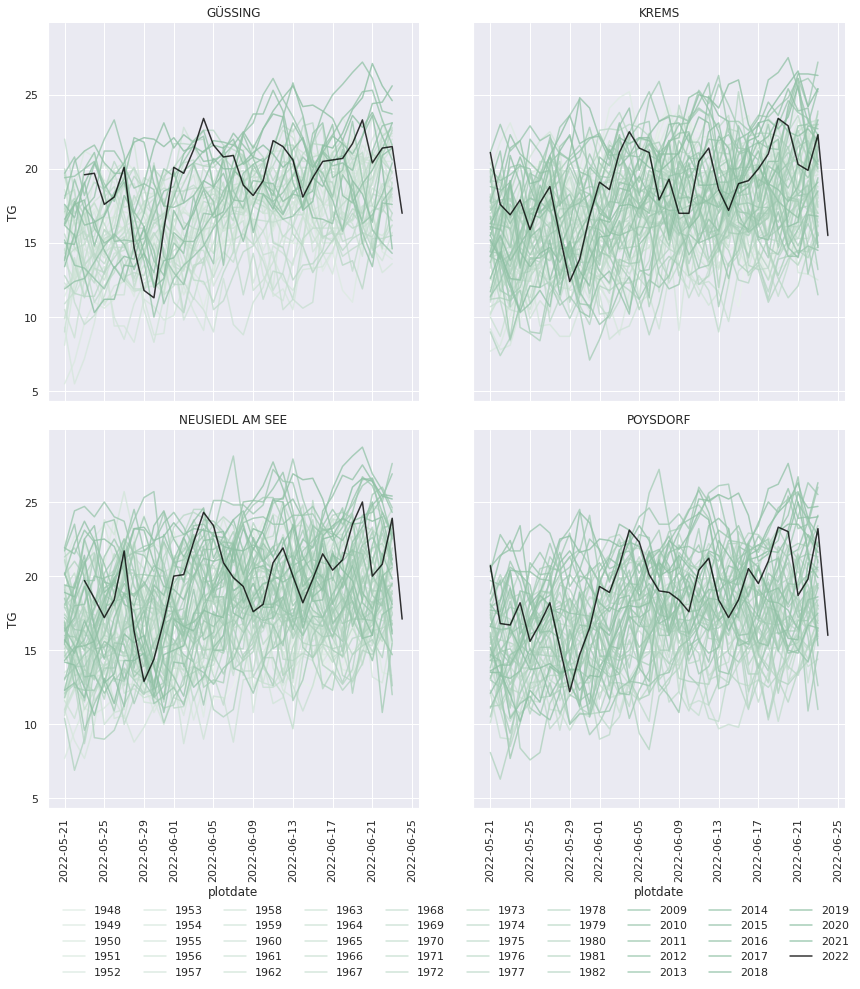

In [26]:
countOfYears = ecadzamg['year'].nunique()

#fig, ax = plt.subplots()
#d = {'color': ['lightgray'] * (ecadSimple['year'].nunique() - 1) +  ['red']}
#g = sns.FacetGrid(ecadSimple, col="name", hue='year', palette="coolwarm", col_wrap=2, height=6)
d = {'color': sns.light_palette("seagreen", countOfYears * 2)[0:(countOfYears - 1)] +  ['black']}
g = sns.FacetGrid(ecadzamg, col="name", hue='year', hue_kws=d, col_wrap=2, height=6) # gemeindename
g.map(sns.lineplot, "plotdate", "TG", alpha=.8)
g.set_titles(col_template = '{col_name}')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
#plt.tight_layout()
g.add_legend()
h,l = g.axes[0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(h, l, ncol= 10, loc='lower center'
             , bbox_to_anchor=(0.5, -0.15)
             , frameon=False
            )

Ansicht des Zeitraums 21.5. bis 25.6. in den Jahren 1948 bis 2022. Auch wenn aus den aktuellen Daten nicht klar ersichtlich ist, dass es heuer vielleicht heißer was als in den vergangenen Jahren, kann man aus diesem Ausschnitt sehr gut erkennen, dass die Temperturen eine starke Tendenz nach oben zeigen.

# GeDaBa-Daten als Summe der ausgewählten Gemeinden und ECAD-Daten

In dieser Visualisierung wird versucht, die Summen der Anbauflächen der ausgewählten Gemeinden rund um die betrachteten Wetterstationen  aus der GeDaBa mit den Regendaten und Temperaturdaten des ECAD zu überlagern. Um eine Entwicklung zu zeigen, wurden die Regen- bzw.  Temperaturdaten schon ab 1970 eingezeichnet. Damit die Temperaturwerte besser sichtbar sind, wurden sie mit dem Faktor 1000 skaliert.

In [27]:
gedabaYear = gedaba.groupby(["jahr", "SOUNAME", "merkmal"]).agg({'wert':'sum'}).reset_index()
print(gedabaYear.dtypes)
gedabaYear = gedabaYear.rename(columns={"jahr": "Jahr", "SOUNAME": "Station", "merkmal": "variable", "wert": "value"})
print(gedabaYear)
#gedabaYear = gedabaYear.pivot(index=['jahr','SOUNAME'], columns='merkmal', values='wert').reset_index()
#gedabaYear

jahr         int64
SOUNAME     object
merkmal     object
wert       float64
dtype: object
     Jahr          Station    variable        value
0    2000          GÜSSING  Weingärten    30.730000
1    2000          GÜSSING      Weizen  1307.050000
2    2000            KREMS  Weingärten  3879.279953
3    2000            KREMS      Weizen   791.190004
4    2000  NEUSIEDL AM SEE  Weingärten  2841.630000
..    ...              ...         ...          ...
171  2021            KREMS      Weizen   512.150000
172  2021  NEUSIEDL AM SEE  Weingärten  2361.356200
173  2021  NEUSIEDL AM SEE      Weizen  3110.276300
174  2021         POYSDORF  Weingärten  2416.350014
175  2021         POYSDORF      Weizen  8403.109932

[176 rows x 4 columns]


In [28]:
# create yearly data
ecadN = ecad.rename(columns={"year": "Jahr", "name": "Station", "RR": "Regen", "TG": "Temperatur"})
ecadYear = ecadN.groupby(["Jahr", "Station"]).agg({'Regen':'sum', 'Temperatur':'mean'}).reset_index()
ecadYear = ecadYear.melt(id_vars=['Jahr', 'Station'], value_vars=['Regen', 'Temperatur'])
ecadYear.loc[ecadYear.variable == 'Temperatur', "value"] = ecadYear.value * 1000
print(ecadYear.dtypes)
print(ecadYear)

Jahr          int64
Station      object
variable     object
value       float64
dtype: object
     Jahr          Station    variable         value
0    1936            KREMS       Regen   5107.000000
1    1936  NEUSIEDL AM SEE       Regen   7421.000000
2    1937            KREMS       Regen   6602.000000
3    1937  NEUSIEDL AM SEE       Regen   7587.000000
4    1938            KREMS       Regen   3734.000000
..    ...              ...         ...           ...
547  2020         POYSDORF  Temperatur  11448.360656
548  2021          GÜSSING  Temperatur  11090.958904
549  2021            KREMS  Temperatur  10579.178082
550  2021  NEUSIEDL AM SEE  Temperatur  11475.068493
551  2021         POYSDORF  Temperatur  10575.068493

[552 rows x 4 columns]


In [29]:
# concat
# jahr 	merkmal 	SOUNAME 	wert
# year 	name 	variable 	value

final = pd.concat([ecadYear, gedabaYear])
final = final.rename(columns={"variable": "Merkmal", "value": "Wert"})
final.loc[final.Merkmal == 'Regen', "Merkmal"] = "Regen (0,1 l/m²)"
final.loc[final.Merkmal == 'Temperatur', "Merkmal"] = "Temperatur (0.001°)"
final.loc[final.Merkmal == 'Weizen', "Merkmal"] = "Weizen (ha)"
final.loc[final.Merkmal == 'Weingärten', "Merkmal"] = "Weingärten (ha)"
final

# merge 
#final = pd.merge(ecadYear, gedabaYear, how='left'
#                 , left_on=['year','name'], right_on=['jahr','SOUNAME'])
#final = final.drop(columns=['jahr', 'SOUNAME'])
#final = final.rename(columns={"year": "Jahr", "name": "Station", "RR": "Regen", "TG": "Temp"})
#final

,Jahr,Station,Merkmal,Wert
0,1936,KREMS,"Regen (0,1 l/m²)",5107.000000
1,1936,NEUSIEDL AM SEE,"Regen (0,1 l/m²)",7421.000000
2,1937,KREMS,"Regen (0,1 l/m²)",6602.000000
3,1937,NEUSIEDL AM SEE,"Regen (0,1 l/m²)",7587.000000
4,1938,KREMS,"Regen (0,1 l/m²)",3734.000000
...,...,...,...,...
171,2021,KREMS,Weizen (ha),512.150000
172,2021,NEUSIEDL AM SEE,Weingärten (ha),2361.356200
173,2021,NEUSIEDL AM SEE,Weizen (ha),3110.276300
174,2021,POYSDORF,Weingärten (ha),2416.350014


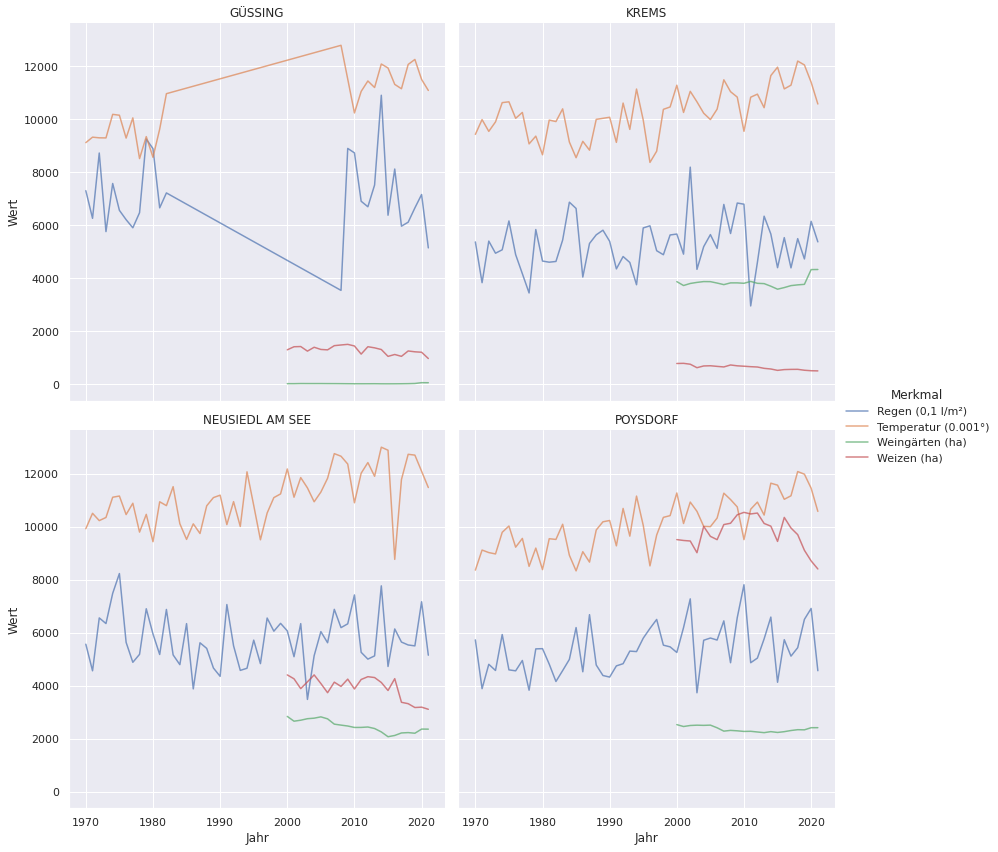

In [30]:
p = sns.FacetGrid(final.query('Jahr >= 1970'), col="Station", hue='Merkmal', col_wrap=2, height=6)
p.map(sns.lineplot, "Jahr", "Wert", alpha=.7)
p.set_titles(col_template = '{col_name}')
p.add_legend()
plt.show()

Ansicht des Zeitraums 1970 bis 2020 für 35 Gemeinden rund um die Wetterstationen Güssing, Krems, Neusield am See, Poysdorf. Durch den relativ kurzen Zeitraum sieht man hier deutlich die Temperatursteigerung. Der Weizenanbau geht in allen vier betrachteten Regionen  zurück, man könnte vermuten, dass das mit den Temperatursteigerungen in Zusammenhang steht. Beim Weinanbau sieht man eher die Tendenz nach oben bzw. in Krems sowie Neusiedl sogar eine deutliche Steigerung. Die Vermutung scheint sich also zu bewahrheiten, dass va. Temperatursteigerungen eine Veränderung in der landwirtschaflichen Produktion nach sich ziehen muss. 